In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Prepare the data

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_absolute_error, r2_score

# Modeling

### ResNet18

In [7]:
import os
import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import r2_score, mean_absolute_error


## 2nd chance

✅ Modifications and Enhancements Made:
Switched to ResNet18 with a Custom Output Layer

Replaced the final fully connected layer to predict a single bone age value.

Added a Dropout(p=0.4) before the final layer to reduce overfitting.

Advanced Data Augmentations

Applied strong image augmentations using RandomHorizontalFlip, RandomRotation, ColorJitter, and RandomAffine to make the model more robust and improve generalization.

Weight Decay & Learning Rate Scheduler

Added weight_decay=1e-5 in the Adam optimizer to regularize and reduce overfitting.

Used ReduceLROnPlateau scheduler to reduce learning rate automatically when validation performance plateaus.

Early Stopping Logic

Monitored validation MAE and stopped training early if no improvement was seen for 5 consecutive epochs.

Model Checkpointing and Evaluation

Saved the best model based on the lowest validation MAE.

After training, the best model is loaded and evaluated on a separate test set

In [8]:
class BoneAgeDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, str(self.data.iloc[idx]['ID']) +".png")
        image = Image.open(img_name).convert("RGB")
        label = torch.tensor(self.data.iloc[idx]['Boneage'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
# =============================
# Transforms
# =============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [10]:
# Load Data
csv_path = '/kaggle/input/rsna-bone-age/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_train.csv'
img_path = '/kaggle/input/rsna-bone-age/RSNA_train/images'

dataset = BoneAgeDataset(csv_path, img_path, transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)


# تحميل بيانات الاختبار
test_csv = '/kaggle/input/rsna-bone-age/RSNA_Annotations/RSNA_Annotations/BONEAGE/boneage_val.csv'
test_img_path = '/kaggle/input/rsna-bone-age/RSNA_val/images'

test_dataset = BoneAgeDataset(test_csv, test_img_path, transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [11]:
# =============================
# Model
# =============================
class BoneAgeResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(in_features, 1)
        )

    def forward(self, x):
        return self.backbone(x).squeeze(1)


In [14]:
# =============================
# Training Setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BoneAgeResNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)



# =============================
# Training Loop
# =============================
best_val_mae = float('inf')
patience_counter = 0

train_mses = []
train_maes = []
val_maes = []
train_r2s = []
val_r2s = []

for epoch in range(50):
    start_time = time.time()

    model.train()
    train_losses, train_preds, train_targets = [], [], []
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend(outputs.detach().cpu().numpy())
        train_targets.extend(targets.cpu().numpy())

    model.eval()
    val_losses, val_preds, val_targets = [], [], []
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            val_losses.append(loss.item())
            val_preds.extend(outputs.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())

    train_r2 = r2_score(train_targets, train_preds)
    val_r2 = r2_score(val_targets, val_preds)
    train_mae = mean_absolute_error(train_targets, train_preds)
    val_mae = mean_absolute_error(val_targets, val_preds)

    scheduler.step(val_mae)

    train_mses.append(sum(train_losses)/len(train_losses))
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    train_r2s.append(train_r2)
    val_r2s.append(val_r2)

    print(f"Epoch [{epoch+1}/20] | Train MSE: {train_mses[-1]:.3f} | Train MAE: {train_mae:.2f} "
          f"| Val MAE: {val_mae:.2f} | R² Train: {train_r2:.3f} | R² Val: {val_r2:.3f} | "
          f"Time: {time.time() - start_time:.2f}s")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), "best_resnet_model.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= 5:
            print("Early stopping triggered")
            break

Epoch [1/20] | Train MSE: 14807.597 | Train MAE: 116.54 | Val MAE: 107.97 | R² Train: -7.665 | R² Val: -6.583 | Time: 561.37s
Epoch [2/20] | Train MSE: 10298.029 | Train MAE: 97.39 | Val MAE: 83.46 | R² Train: -5.027 | R² Val: -3.693 | Time: 559.57s
Epoch [3/20] | Train MSE: 6122.403 | Train MAE: 74.57 | Val MAE: 66.65 | R² Train: -2.582 | R² Val: -1.968 | Time: 561.25s
Epoch [4/20] | Train MSE: 2907.937 | Train MAE: 50.18 | Val MAE: 49.05 | R² Train: -0.698 | R² Val: -0.625 | Time: 559.97s
Epoch [5/20] | Train MSE: 1201.126 | Train MAE: 30.51 | Val MAE: 20.24 | R² Train: 0.297 | R² Val: 0.649 | Time: 558.69s
Epoch [6/20] | Train MSE: 525.312 | Train MAE: 18.76 | Val MAE: 15.30 | R² Train: 0.693 | R² Val: 0.780 | Time: 557.06s
Epoch [7/20] | Train MSE: 320.912 | Train MAE: 14.31 | Val MAE: 11.45 | R² Train: 0.812 | R² Val: 0.870 | Time: 553.84s
Epoch [8/20] | Train MSE: 264.705 | Train MAE: 12.80 | Val MAE: 11.31 | R² Train: 0.846 | R² Val: 0.871 | Time: 563.99s
Epoch [9/20] | Train MS

In [15]:
# =============================
# Evaluation on Test Set
# =============================
model.load_state_dict(torch.load("best_resnet_model.pth"))
model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        test_preds.extend(outputs.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

mae = mean_absolute_error(test_targets, test_preds)
r2 = r2_score(test_targets, test_preds)
print(f"\nTest MAE: {mae:.2f} | Test R²: {r2:.3f}")



Test MAE: 9.80 | Test R²: 0.904


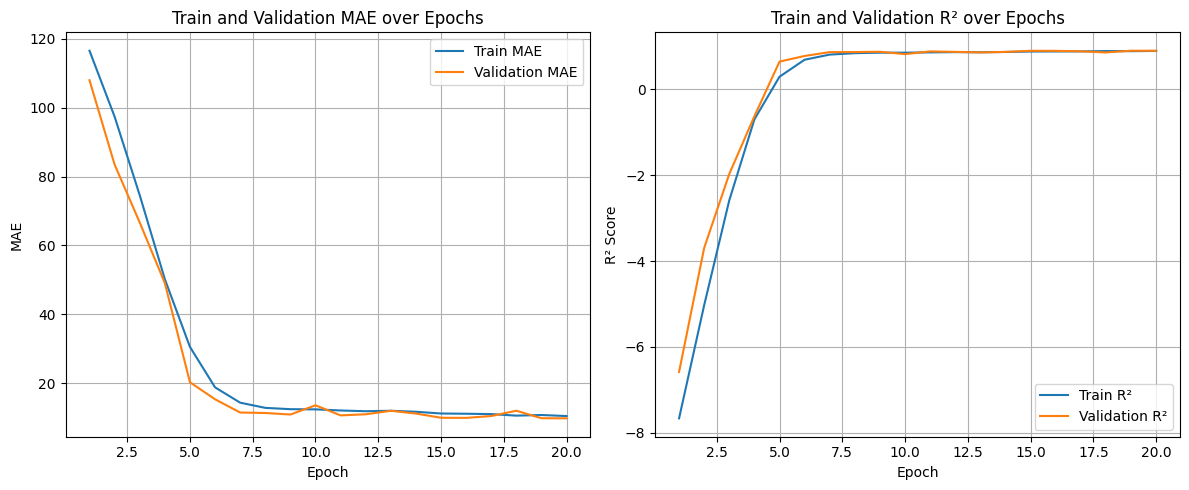

In [16]:
# =============================
# Plotting
# =============================
epochs_range = range(1, len(train_maes) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_maes, label='Train MAE')
plt.plot(epochs_range, val_maes, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Train and Validation MAE over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_r2s, label='Train R²')
plt.plot(epochs_range, val_r2s, label='Validation R²')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Train and Validation R² over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
